# Welcome to the DBUxHalfspace hackathon
## Table of contents

- [First steps](#step0)
- [File structure](#struktur)
- [Event](#event)
- [Tracking](#tracking)
- [Event -> tracking](#event_to_tracking)

---

<a id="step0"></a>

# STEP 0 
DOWNLOAD DATA and VIDEOS FROM HERE: https://www.dropbox.com/scl/fo/g7bh4jqsnjtm28cp9c95p/h/data?e=1&subfolder_nav_tracking=1&dl=0


# STEP 1
Move the downloaded files into the /data folder within this directory


# STEP 2
If you've done Step 1 and 2 correctly, you should see the following folders 📁 and the following .csv files 📄 inside /data:
- 📁 H_EURO2024/
- 📁 Q_EURO2025/
- 📁 U21_EURO2025/
- 📁 videos/
- 📄 events.csv
- 📄 subs.csv


In [1]:
#list the files inside data
! ls data

H_EURO2024   Q_EURO2025   U21_EURO2025 events.csv   subs.csv


<a id="struktur"></a>

## File structure

Your files should now be structured like this:

In [2]:
import src.utils as ut
from pathlib import Path
ut.print_tree(Path("."))

├── data
│   ├── H_EURO2024
│   │   ├── 2036161_Germany_Scotland/
│   │   │   ├── tracking_away.csv
│   │   │   └── tracking_home.csv
│   │   └── ... (52 more games)
│   ├── Q_EURO2025
│   │   ├── BEL-ITA_EURO2025/
│   │   │   ├── tracking_away.csv
│   │   │   └── tracking_home.csv
│   │   └── ... (30 more games)
│   ├── U21_EURO2025
│   │   ├── CZE-ENG_U21EUROS25/
│   │   │   ├── away_tracking.csv
│   │   │   └── home_tracking.csv
│   │   └── ... (30 more games)
│   ├── events.csv
│   └── subs.csv
├── pngs
│   ├── Tracking_data_structure.png
│   └── wyscout_pitch_coordinates.png
├── presentation_template
│   ├── præsentation_skabelon_keynote_EN.key
│   ├── præsentation_skabelon_keynote_EN.pdf
│   └── præsentation_skabelon_keynote_EN.pptx
├── src
│   ├── configs
│   │   ├── directories.py
│   │   └── static.py
│   ├── data_loader.py
│   └── utils.py
├── intro.ipynb
├── pyproject.toml
├── README.md
└── uv.lock


And you should be all set to explore the data!

<a id="event"></a>

## Event data
Event data describes the ball's movements during the match. 
The event data for this hackathon is produced by Wyscout, and their event data "lives" in the following coordinate system:

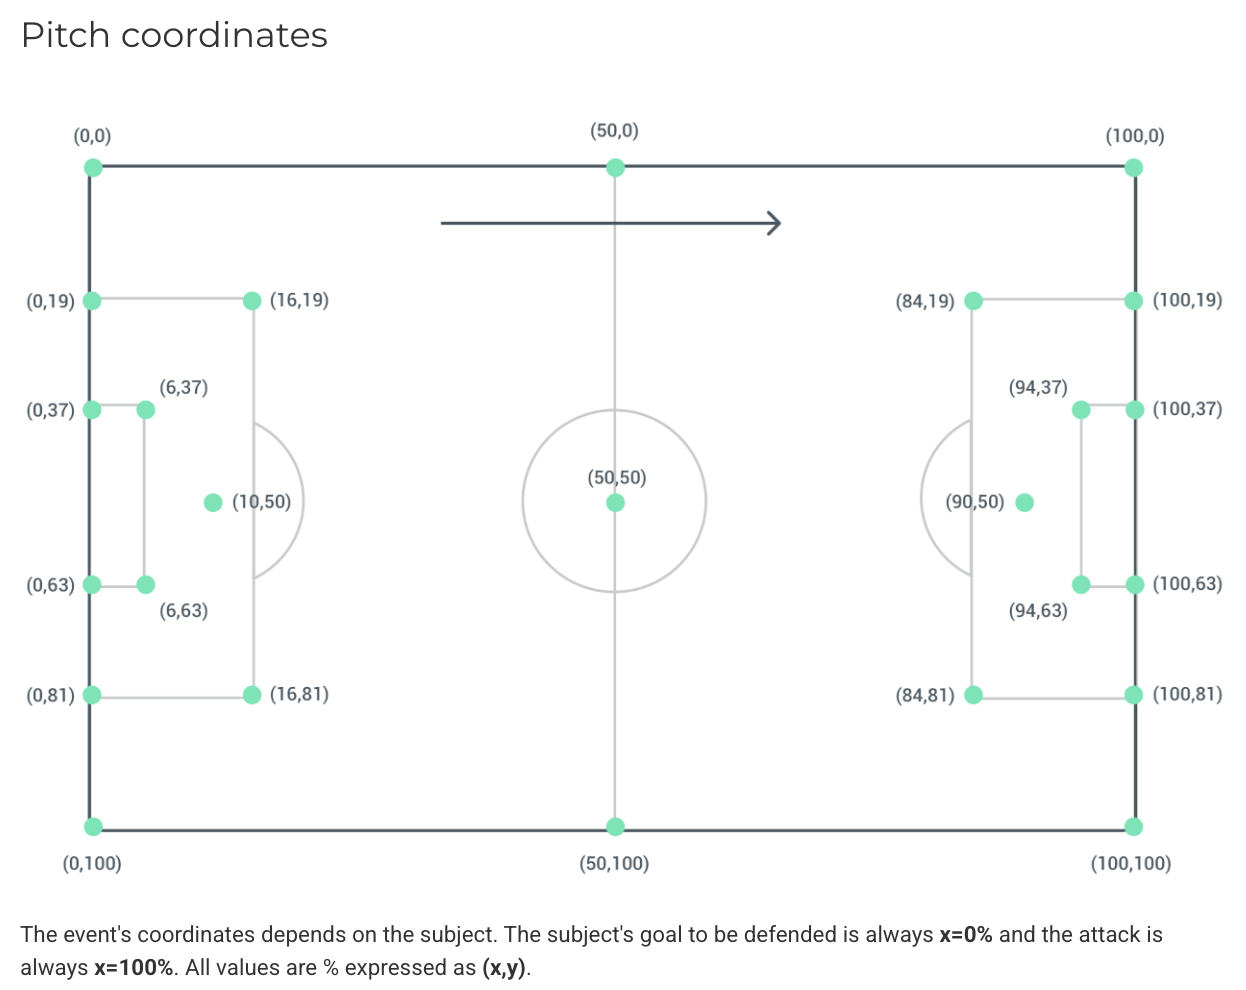

In [3]:
from IPython.display import Image
from src.configs.directories import Directories
Image(filename='pngs/wyscout_pitch_coordinates.png')

You read the event data like this:

In [4]:
import pandas as pd
events = pd.read_csv(Directories.DATA_PATH / "events.csv")
events.head()

,matchId,label,eventId,typePrimary,matchPeriod,minute,second,matchTimestamp,videoTimestamp,relatedEventId,...,duration,posStartX,posStartY,posEndX,posEndY,teamName,teamImageUrl,infractionType,yellowcard,redCard
0,5544194,"Germany - Scotland, 5 - 1",2218716641,pass,1H,0,1,00:00:01.480,"2,480136",2218716642,...,51.502,51,50,81,39,Germany,https://cdn5.wyscout.com/photos/team/public/81...,NaN,NaN,NaN
1,5544194,"Germany - Scotland, 5 - 1",2218716642,pass,1H,0,4,00:00:04.389,"5,389146",2218716645,...,51.502,51,50,81,39,Germany,https://cdn5.wyscout.com/photos/team/public/81...,NaN,NaN,NaN
2,5544194,"Germany - Scotland, 5 - 1",2218716645,duel,1H,0,7,00:00:07.267,"8,267713",2218716773,...,51.502,51,50,81,39,Germany,https://cdn5.wyscout.com/photos/team/public/81...,NaN,NaN,NaN
3,5544194,"Germany - Scotland, 5 - 1",2218716768,duel,1H,0,7,00:00:07.287,"8,287418",2218716773,...,51.502,51,50,81,39,Scotland,https://cdn5.wyscout.com/photos/team/public/89...,NaN,NaN,NaN
4,5544194,"Germany - Scotland, 5 - 1",2218716773,pass,1H,0,8,00:00:08.240,"9,240795",2218716776,...,51.502,51,50,81,39,Scotland,https://cdn5.wyscout.com/photos/team/public/89...,NaN,NaN,NaN


And you can now explore the events -- for instance the types of events and how often they occur:


In [5]:
events.typePrimary.value_counts()

typePrimary
pass                       98460
duel                       42014
touch                      15257
interception                8326
game_interruption           7490
throw_in                    4290
free_kick                   2878
shot                        2669
infraction                  2659
goal_kick                   1831
clearance                   1286
corner                      1133
shot_against                1026
acceleration                 749
goalkeeper_exit              355
offside                      341
fairplay                      70
postmatch_penalty             61
postmatch_penalty_faced       55
penalty                       36
own_goal                      15
Name: count, dtype: int64

You can read about the different types of events (definitions, examples, etc.) here: [Wyscout Event Types](https://dataglossary.wyscout.com)

And for instance, you can show the shots from a single game like this:

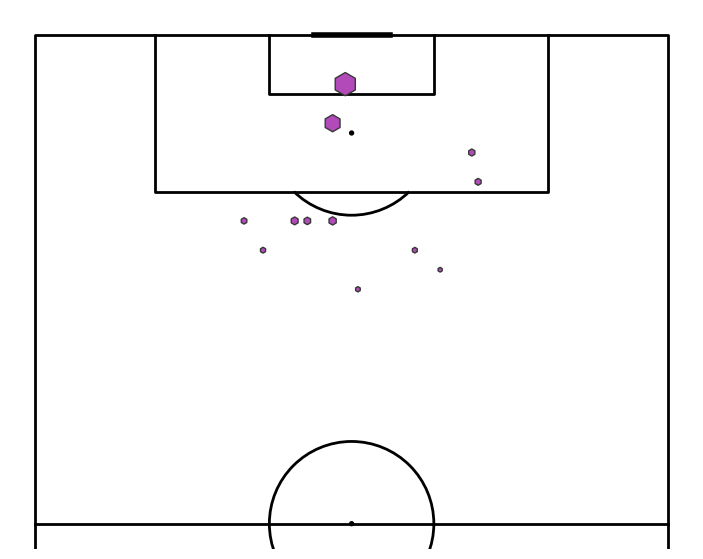

In [6]:
#plenty of great plotting functionality here: https://mplsoccer.readthedocs.io/en/latest/gallery/index.html
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

pitch = VerticalPitch(pitch_type='wyscout', pitch_color='None', line_color='Black',half=True)
fig, ax = plt.subplots(figsize=(10, 7))
pitch.draw(ax=ax)

#filter out Denmark U21 shots against Ukraine U21
den_u21_against_ukraine_shots = events[(events.teamName == 'Denmark Under 21') & (events.label == 'Ukraine U21 - Denmark U21, 2 - 3') & (events.typePrimary == 'shot')].copy()

#scatter the shots on the pitch, scale size by xG
sc = pitch.scatter(den_u21_against_ukraine_shots.x, den_u21_against_ukraine_shots.y,
                   s=(den_u21_against_ukraine_shots.xG * 500),
                   c="#b24bb9",  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   marker='h',# for other markers types see: https://matplotlib.org/api/markers_api.html
                   ax=ax)

<a id="tracking"></a>

## Tracking data

The tracking data has been produced by three different providers (one per tournament). Since every provider uses their own coordinate system, we always transform the data into a "DBU tracking data format" that looks like this:

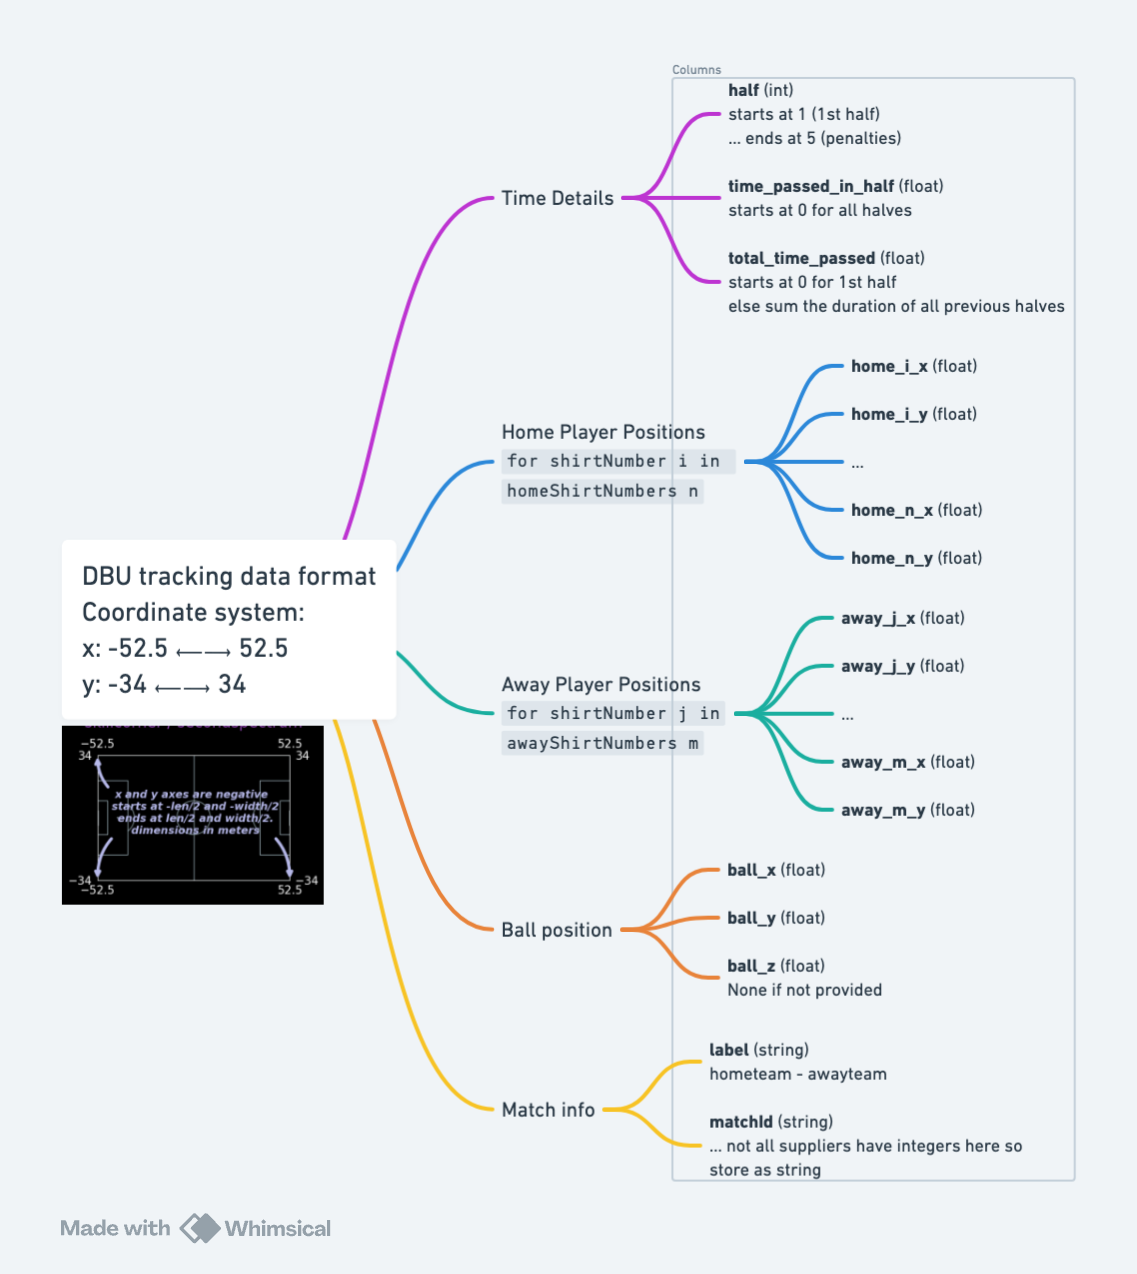

In [7]:
from IPython.display import Image
Image(filename=Directories.REPO_PATH / 'pngs/tracking_data_structure.png')

Notice that the home team always attacks left to right, and that the center of the pitch is at (0,0) -- both these things are different from wyscout's coordinate system.

You can read in the tracking data and plot it like this:

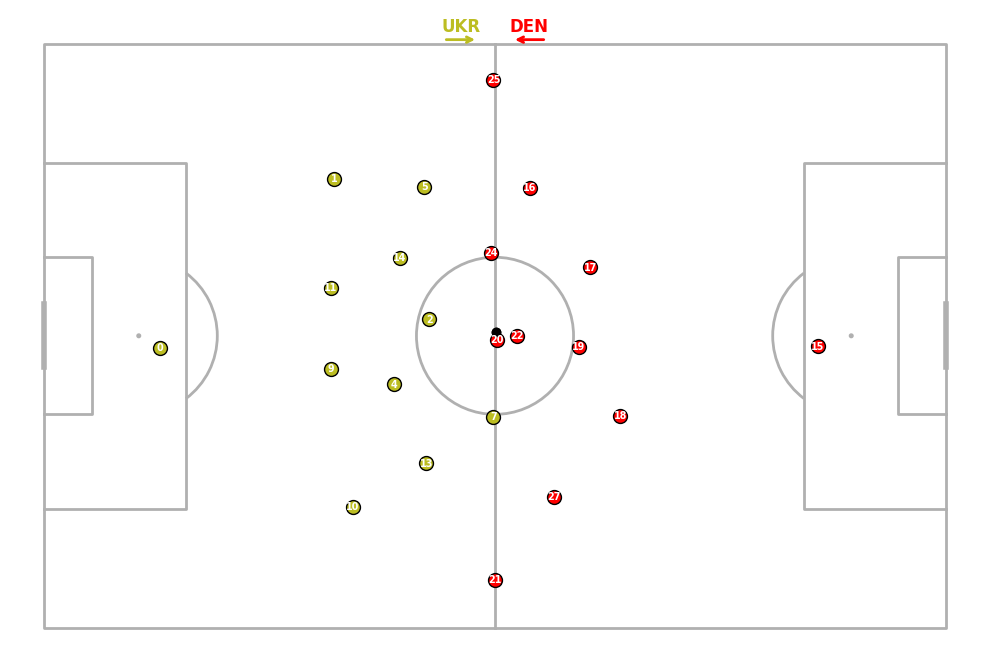

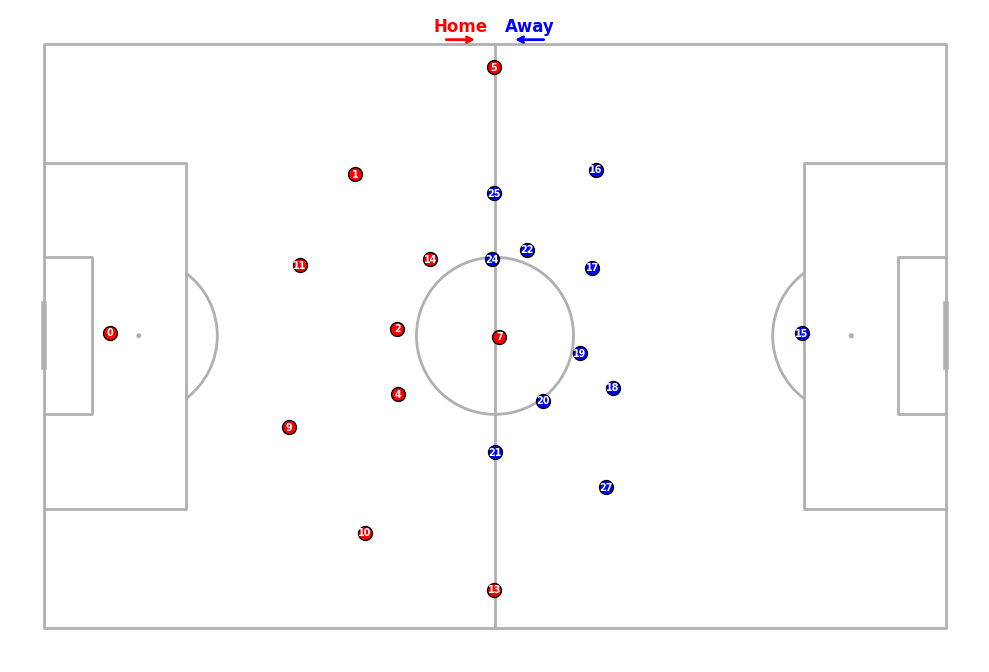

In [ ]:
game = 'UKR-DEN_U21EUROS25'

#read in the Ukraine U21 vs Denmark U21 tracking data
home = pd.read_csv(Directories.DATA_PATH / f'{Directories.U21_PATH}/{game}/home_tracking.csv')
away = pd.read_csv(Directories.DATA_PATH / f'{Directories.U21_PATH}/{game}/away_tracking.csv')

#plot first frame in first half
ut.plot_tracking(home=home, away=away, half=1, time=0, home_color='tab:olive', away_color='red',home_label='UKR',away_label='DEN')

#plot first frame in second half with default colors (home is red and away is blue) and default team labels
ut.plot_tracking(home, away, 2, 0)

<a id="event_to_tracking"></a>

# Combining event with tracking data
The way to combine event and tracking data is simple:

Find the half and timestamp from the event row and plot the closest tracking frame (the plotting function already has this functionality, so all we have to do is extract half and timestamp from the event).

There's a function in utils (ut) extract_half_and_time_passed_in_half(event) that does this.

So, if we want to find the tracking data for the first Danish shot in the U21's game against Ukraine:

In [24]:
half, time_passed_in_half = ut.extract_half_and_time_passed_in_half(event=den_u21_against_ukraine_shots.iloc[0])

And we can plot the corresponding tracking frame like this:

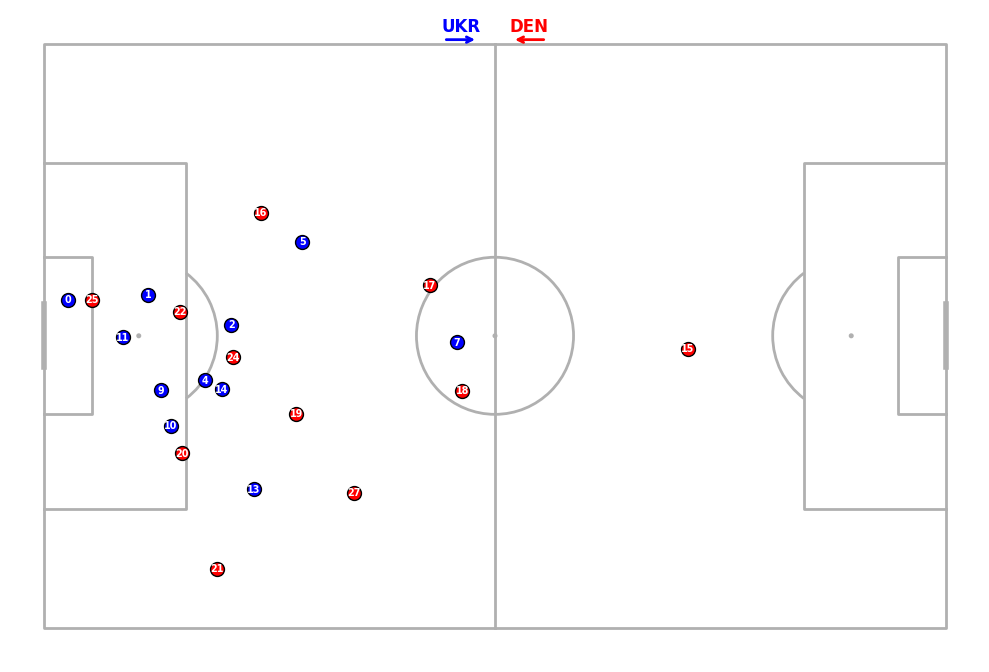

In [25]:
ut.plot_tracking(home=home, away=away, half=1, time=time_passed_in_half, home_color='blue', away_color='red',home_label='UKR',away_label='DEN')